In [1]:
# Import Python modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Machine learning modules

from sklearn.model_selection import train_test_split 

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix 

- standardize the names in the 'Condition' column by converting them all to the same format

In [257]:
# convert all the strings in the 'Condition' column to lowercase
# vax_trials_filtered['Condition'] = vax_trials_filtered['Condition'].str.lower()

In [258]:
# # Define the mapping dictionary
# mapping = {
#     'influenza': 'influenza',
#     'meningococcal': 'meningococcal',
#     'sars-cov-2': 'sars-cov-2',
#     'covid': 'sars-cov-2',
#     'dengue': 'dengue',
#     'hand': 'hand-foot-mouth disease',
#     'hpv': 'hpv',
#     'hiv': 'hiv',
#     'papilomavirus': 'papilomavirus',
#     'pneumo': 'pneumococcal',
#     'streptococcal': 'streptococcal'
    
# }

# # Loop through the mapping dictionary and apply replacements
# for old_value, new_value in mapping.items():
#     vax_trials_filtered.loc[vax_trials_filtered['Condition'].str.contains(old_value), 'Condition'] = new_value


### Retrieve data from AACT

1. Use this link: [AACT Download](https://aact.ctti-clinicaltrials.org/download)
2. Select pipe-delimited files.
3. Download the latest version of the "Current Month's Daily Static Copies."

- You can find information about each table in the AACT dataset [here](https://aact.ctti-clinicaltrials.org/data_dictionary).



#### conditions.txt
- Name(s) of the disease(s) or condition(s) studied in the clinical study, or the focus of the clinical study. Can include NLM's Medical Subject Heading (MeSH)-controlled vocabulary terms.

In [32]:
# Read conditions file from AACT database
file_path = './AACT_20240125/conditions.txt'

# select only the nct_id, reason, and count columns
conditions = pd.read_csv(file_path, header=0, sep="|", usecols=[1,3])

# Display the DataFrame
conditions.head()

,nct_id,downcase_name
0,NCT05522114,tmd
1,NCT03533179,drug overdose
2,NCT05977569,fasting
3,NCT05976022,mdd
4,NCT04972968,polymyalgia rheumatica


In [50]:
# Group rows by the 'nct_id' column and aggregate the 'name' column using a custom lambda function to join strings
conditions = conditions.groupby('nct_id')['downcase_name'].agg(lambda x: ', '.join(x)).reset_index()
conditions.head()

,nct_id,downcase_name
0,NCT00000102,congenital adrenal hyperplasia
1,NCT00000104,lead poisoning
2,NCT00000105,cancer
3,NCT00000106,rheumatic diseases
4,NCT00000107,"heart defects, congenital"


#### calculated_values.txt

- An AACT-provided table that contains info that's been calculated from the information received from ClinicalTrials.gov. For example, number_of_facilities and actual_duration are provided in this table.

In [33]:
# Read calculated_values file from AACT database
file_path = './AACT_20240125/calculated_values.txt'

# select only the nct_id, reason, and count columns
calculated_values = pd.read_csv(file_path, header=0, sep="|", usecols=[1,7])

# Display the DataFrame
calculated_values.head()

,nct_id,actual_duration
0,NCT00671619,3.0
1,NCT04838314,26.0
2,NCT05946148,36.0
3,NCT00911664,8.0
4,NCT00867724,46.0


#### studies.txt

- Basic info about study, including study title, date study registered with ClinicalTrials.gov, date results first posted to ClinicalTrials.gov, dates for study start and completion, phase of study, enrollment status, planned or actual enrollment, number of study arms/groups, etc.

In [34]:
# Read facilities file from AACT database
file_path = './AACT_20240125/studies.txt'

# select only the nct_id, reason, and count columns
studies = pd.read_csv(file_path, header=0, sep="|", usecols=[0,35,37,38])

# Filter completed studies and create a copy
studies_filtered = studies[studies['overall_status'] == 'Completed']

# Display the DataFrame
studies_filtered.head()

,nct_id,overall_status,phase,enrollment
0,NCT00814619,Completed,Phase 2,68.0
2,NCT01025661,Completed,Not Applicable,14.0
4,NCT00641147,Completed,Phase 2,44.0
5,NCT00460239,Completed,Phase 2,12.0
6,NCT01021605,Completed,Not Applicable,21.0


In [19]:
# Get the position of each column in the studies df

# column_positions = {col: studies.columns.get_loc(col) for col in studies.columns}
# print(column_positions)

#### drop_withdrawals.txt

- Summarized information about how many participants withdrew from the study, when and why. This information explains disposition of participants relative to the numbers starting and completing the study (enumerated in the Milestones table)

In [35]:
# Read drop_withdrawals file from AACT database
file_path = './AACT_20240125/drop_withdrawals.txt'

# select only the nct_id, reason, and count columns
drop_withdrawals = pd.read_csv(file_path, header=0, sep="|", usecols=[1,5,6])

# Display the DataFrame
drop_withdrawals.head()

,nct_id,reason,count
0,NCT01443026,Physician Decision,1.0
1,NCT01443026,Physician Decision,0.0
2,NCT01443026,Death,0.0
3,NCT01443026,Death,1.0
4,NCT01443026,Withdrawal by Subject,0.0


#### milestones.txt

- Information summarizing the progress of participants through each stage of a study, including the number of participants who started and completed the trial. Enumeration of participants not completing the study is included in the Drop_Withdrawals table.

In [36]:
# Read milestones file from AACT database
file_path = './AACT_20240125/milestones.txt'

# select only the nct_id, title, and count columns
milestones = pd.read_csv(file_path, header=0, sep="|", usecols=[1,4,7])

# Display the DataFrame
milestones.head()

,nct_id,title,count
0,NCT02829723,STARTED,5.0
1,NCT02829723,STARTED,7.0
2,NCT03907579,STARTED,100.0
3,NCT03074500,STARTED,11.0
4,NCT03074500,STARTED,11.0


#### interventions.txt
- The interventions or exposures (including drugs, medical devices, procedures, vaccines, and other products) of interest to the study, or associated with study arms/groups.

In [37]:
# Read interventions file from AACT database
file_path = './AACT_20240125/interventions.txt'

# Select only the nct_id, title, and count columns
interventions = pd.read_csv(file_path, header=0, sep="|", usecols=[1,3])

# Display the DataFrame
interventions.head()

,nct_id,name
0,NCT03182764,No intervention
1,NCT05916014,Diagnostic Test: The diagnosis of Artificial I...
2,NCT05916001,Placebo
3,NCT00195676,adalimumab
4,NCT00228332,Administration of zinkgluconaat or placebo


In [38]:
# Make a lowercase copy of the 'name' column
interventions['name'] = interventions['name'].str.lower()

# Drop rows with NaN values in the 'name' column
interventions = interventions.dropna(subset=['name'])

# Filter the rows that contain the word 'vaccine' in the name column
vax_intervention = interventions[interventions['name'].str.contains('vaccine')]
vax_intervention.head()

,nct_id,name
151,NCT00373412,vcl ct02 pdna vaccine
152,NCT00373412,towne cmv vaccine
258,NCT02429440,peptide vaccine
360,NCT00257127,pneumococcal 7-valent conjugate vaccine
372,NCT00257127,pneumococcal polysaccharide vaccine


In [49]:
# Group rows by the 'nct_id' column and aggregate the 'name' column using a custom lambda function to join strings
vax_intervention = vax_intervention.groupby('nct_id')['name'].agg(lambda x: ', '.join(x)).reset_index()
vax_intervention.head()

,nct_id,name
0,NCT00000105,intracel klh vaccine
1,NCT00000583,hepatitis b vaccines
2,NCT00000630,gp160 vaccine (microgenesys)
3,NCT00000631,gp160 vaccine (microgenesys)
4,NCT00000633,"gp160 vaccine (immuno-ag), hepatitis b vaccine..."


#### reported_events.txt
- Summary information about reported adverse events (any untoward or unfavorable medical occurrence to participants, including abnormal physical exams, laboratory findings, symptoms, or diseases), including serious adverse events, other adverse events, and mortality.

In [39]:
# Read interventions file from AACT database
file_path = './AACT_20240125/reported_events.txt'

# select only the nct_id, title, and count columns
reported_events = pd.read_csv(file_path, header=0, sep="|", usecols=[1,5,8,9,11,13,14])

# Display the DataFrame
reported_events.head()

,nct_id,event_type,subjects_affected,subjects_at_risk,event_count,adverse_event_term,frequency_threshold
0,NCT02305888,serious,1.0,63,NaN,Inguinal hernia,3.0
1,NCT02305888,serious,0.0,63,NaN,Inguinal hernia,3.0
2,NCT02305888,serious,0.0,62,NaN,Inguinal hernia,3.0
3,NCT02305888,other,28.0,63,NaN,Application site pain,3.0
4,NCT01026402,other,0.0,8,0.0,Hypoalbuminaemia,5.0


#### Merge

In [51]:
# Merge 'studies_filtered' and 'vax_intervention' 
vax_trials = pd.merge(studies_filtered, vax_intervention, on='nct_id')

# Remove the duplicates
vax_trials = vax_trials.drop_duplicates()

# Display the df
vax_trials.head()

,nct_id,overall_status,phase,enrollment,name
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po..."
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi..."
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth..."
4,NCT03763565,Completed,NaN,993.0,bivalent or quadrivalent hpv vaccines


In [52]:
# Merge 'vax_trials' and 'conditions'

vax_trials = pd.merge(vax_trials, conditions, on='nct_id')

# Remove the duplicates
vax_trials = vax_trials.drop_duplicates()

# Display the df
vax_trials.head()

,nct_id,overall_status,phase,enrollment,name,downcase_name
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections"
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections
4,NCT03763565,Completed,NaN,993.0,bivalent or quadrivalent hpv vaccines,"uterine cervical dysplasia, papillomavirus vac..."
...,...,...,...,...,...,...
3149,NCT02872311,Completed,Not Applicable,179.0,"high dose influenza vaccine, adjuvanted influe...",immune response
3150,NCT04930003,Completed,Phase 1/Phase 2,244.0,qazcovac-p -covid-19 subunit vaccine,"covid19, sars-cov infection, vaccine adverse r..."
3151,NCT01859143,Completed,Phase 4,300.0,trivalent influenza vaccine,"influenza, healthy"
3152,NCT01381575,Completed,Phase 3,1447.0,gsk biologicals' hpv vaccine 580299,"infections, papillomavirus"


In [53]:
# Rename columns for clarity
vax_trials = vax_trials.rename(columns={'name':'vaccine_name', 'downcase_name':'condition_name'})
vax_trials.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections"
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections
4,NCT03763565,Completed,NaN,993.0,bivalent or quadrivalent hpv vaccines,"uterine cervical dysplasia, papillomavirus vac..."


#### Merge: analysis and visualization

In [54]:
# Merge the vaccine clinical trials file with the drop withdrawals file on the NCT Id
vax_trials_with_dropouts = pd.merge(vax_trials, drop_withdrawals, on='nct_id')
vax_trials_with_dropouts.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,reason,count
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",Lost to Follow-up,1.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",Lost to Follow-up,1.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",Lost to Follow-up,0.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",Withdrawal by Subject,4.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",Withdrawal by Subject,5.0


In [55]:
# Rename columns for clarity
vax_trials_with_dropouts = vax_trials_with_dropouts.rename(columns={'reason':'reason_dropout', 'count':'count_dropout'})
vax_trials_with_dropouts.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,reason_dropout,count_dropout
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",Lost to Follow-up,1.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",Lost to Follow-up,1.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",Lost to Follow-up,0.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",Withdrawal by Subject,4.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",Withdrawal by Subject,5.0


In [72]:
# Merge the vaccine clinical trials file with the milestones file on the NCT Id
vax_trials_with_milestones = pd.merge(vax_trials, milestones, on='nct_id')
vax_trials_with_milestones.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,title,count
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",STARTED,145.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",STARTED,142.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",STARTED,163.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",COMPLETED,140.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",COMPLETED,136.0


In [73]:
# Rename columns for clarity
vax_trials_with_milestones = vax_trials_with_milestones.rename(columns={'title':'participant_progress', 'count':'participants_number'})
vax_trials_with_milestones.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,participant_progress,participants_number
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",STARTED,145.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",STARTED,142.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",STARTED,163.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",COMPLETED,140.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",COMPLETED,136.0


In [58]:
# Merge the vaccine clinical trials file with the reported_events file on the NCT Id
vax_trials_with_ae = pd.merge(vax_trials, reported_events, on='nct_id')
vax_trials_with_ae.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,event_type,subjects_affected,subjects_at_risk,event_count,adverse_event_term,frequency_threshold
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",serious,1.0,144,1.0,Perianal abcess,5.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",serious,0.0,141,0.0,Perianal abcess,5.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",serious,0.0,160,0.0,Perianal abcess,5.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",other,85.0,142,85.0,Injection site pain,5.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",other,66.0,138,66.0,Injection site pain,5.0


In [59]:
# Drop columns by labels
columns_to_drop = ['overall_status', 'event_count', 'frequency_threshold']
vax_trials_with_ae = vax_trials_with_ae.drop(columns=columns_to_drop)
vax_trials_with_ae.head()

,nct_id,phase,enrollment,vaccine_name,condition_name,event_type,subjects_affected,subjects_at_risk,adverse_event_term
0,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",serious,1.0,144,Perianal abcess
1,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",serious,0.0,141,Perianal abcess
2,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",serious,0.0,160,Perianal abcess
3,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",other,85.0,142,Injection site pain
4,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",other,66.0,138,Injection site pain


#### Cleaning the merged datasets

- Standardize column names across the DataFrames
- Aggregate the count column by summing 
- Aggregate variables to have only one row per ID


- DataFrame 1. 'vax_trials_with_dropouts'

In [63]:
unique_names = vax_trials_with_dropouts['reason_dropout'].unique()
#unique_names

In [64]:
# convert all the strings in the 'reason_dropout' column to lowercase

vax_trials_with_dropouts['reason_dropout'] = vax_trials_with_dropouts['reason_dropout'].str.lower()

In [65]:
# Define a mapping dictionary
mapping = {
    'adverse events': 'adverse event',
    'administrative reasons': 'administrative reason',
    'adverse event or death': 'ae or death',
    'failure to return': 'failed to return'
}

# Apply the mapping to the column
vax_trials_with_dropouts['reason_dropout'] = vax_trials_with_dropouts['reason_dropout'].replace(mapping)

In [66]:
# Define the mapping dictionary
mapping = {
    'move': 'relocate',
    'moved': 'relocate',
    'other': 'others',
    'exclusion': 'met exclusion criteria',
    'non compliance': 'protocol violation/deviation',
    'violation': 'protocol violation/deviation',
    'deviation': 'protocol violation/deviation',
    'physician decision': 'physician decision',
    'adverse event': 'adverse event',
    'withdrawal': 'withdrawal',
    'died ': 'death'
}

# Loop through the mapping dictionary and apply replacements
for old_value, new_value in mapping.items():
    vax_trials_with_dropouts.loc[vax_trials_with_dropouts['reason_dropout'].str.contains(old_value), 'reason_dropout'] = new_value


In [67]:
# Sum of 'count_dropout' grouped by 'nct_id' and 'reason_dropout'
vax_trials_with_dropouts['count_dropout'] = vax_trials_with_dropouts.groupby(['nct_id', 'reason_dropout'])['count_dropout'].transform('sum')


# Remove the duplicates
vax_trials_with_dropouts = vax_trials_with_dropouts.drop_duplicates()
vax_trials_with_dropouts.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,reason_dropout,count_dropout
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",lost to follow-up,2.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",withdrawal,12.0
6,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections,withdrawal,94.0
9,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections,protocol violation/deviation,6.0
12,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections,adverse event,28.0


In [68]:
# Pivot the DataFrame to have one row per unique clinical trial ID (NCTId)
pivot_dropouts = vax_trials_with_dropouts.pivot_table(index=['nct_id', 'overall_status', 'phase', 'enrollment', 'vaccine_name', 'condition_name'],
                          columns='reason_dropout',
                          values='count_dropout',
                          aggfunc='sum',
                          fill_value=0).reset_index()

# Reset the index to make NCTId a column
pivot_dropouts.reset_index(drop=True, inplace=True)


In [71]:
#pivot_dropouts = pivot_dropouts.drop(columns=['reason_dropout'])
pivot_dropouts.head()

reason_dropout,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,*clinical ae,*pregnancy,6-month contact; withdraw before vax 2,administrative problems,...,withdrawn before any study vaccination,withdrawn due to non-compliance,withdrawn unspecified reason,"withdrawn, ahct not suitable treatment","withdrawn, chemo not suitable treatment",withdrew before vaccination,withdrew consent,wrong group allocation,wrong treatment number allocation,year 2 screening failure
0,NCT00003222,Completed,Phase 2,40.0,tetanus peptide melanoma vaccine,melanoma (skin),0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NCT00005780,Completed,Phase 2,26.0,idiotype vaccine,"mantle cell lymphoma, lymphoma, mantle cell",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NCT00006184,Completed,Phase 2,20.0,myeloma immunoglobulin idiotype vaccine,multiple myeloma,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NCT00030823,Completed,Not Applicable,14.0,globo-h-gm2-lewis-y-muc1-32(aa)-stn(c)-tf(c)-t...,breast cancer,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NCT00057330,Completed,Phase 3,8323.0,"hsv vaccine or sb208141, gsk biologicals' glyc...",herpes simplex infection,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- DataFrame 2. 'vax_trials_with_milestones'

In [74]:
# convert all the strings in the 'Reason' column to lowercase

vax_trials_with_milestones['participant_progress'] = vax_trials_with_milestones['participant_progress'].str.lower()

In [75]:
# Sum of 'participants_number' grouped by 'nct_id' and 'participant_progress'
vax_trials_with_milestones['participants_number'] = vax_trials_with_milestones.groupby(['nct_id', 'participant_progress'])['participants_number'].transform('sum')


# Remove the duplicates
vax_trials_with_milestones = vax_trials_with_milestones.drop_duplicates()
vax_trials_with_milestones.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,participant_progress,participants_number
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",started,450.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",completed,436.0
6,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",not completed,14.0
9,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections,started,800.0
12,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections,completed,666.0


In [76]:
# Filter out 'started' status
vax_trials_with_milestones = vax_trials_with_milestones[vax_trials_with_milestones['participant_progress'] != 'started']

# Aggregate status counts at the clinical trial level
completed_counts = vax_trials_with_milestones[vax_trials_with_milestones['participant_progress'] == 'completed'].groupby('nct_id')['participants_number'].sum()
not_completed_counts = vax_trials_with_milestones[vax_trials_with_milestones['participant_progress'] == 'not completed'].groupby('nct_id')['participants_number'].sum()

# Merge aggregated counts
aggregated_milestones = pd.merge(completed_counts, not_completed_counts, on='nct_id', how='outer', suffixes=('_completed', '_not_completed'))


In [77]:
aggregated_milestones.head()

,participants_number_completed,participants_number_not_completed
nct_id,,
NCT00003222,40.0,1.0
NCT00005780,49.0,1.0
NCT00006184,19.0,1.0
NCT00030823,13.0,1.0
NCT00053482,357.0,0.0


In [78]:
# Create binary target column indicating whether there are any dropouts for each clinical trial
# 0: no dropouts, 1: at least one dropout
aggregated_milestones['dropout'] = (aggregated_milestones['participants_number_not_completed'] > 0).astype(int)
aggregated_milestones.reset_index(inplace=True)
aggregated_milestones.head()

,nct_id,participants_number_completed,participants_number_not_completed,dropout
0,NCT00003222,40.0,1.0,1
1,NCT00005780,49.0,1.0,1
2,NCT00006184,19.0,1.0,1
3,NCT00030823,13.0,1.0,1
4,NCT00053482,357.0,0.0,0


In [80]:
# Merge

milestones_info = vax_trials_with_milestones[['nct_id', 'overall_status', 'phase', 'enrollment', 'vaccine_name', 'condition_name']]
aggregated_milestones = pd.merge(milestones_info, aggregated_milestones, on='nct_id')
aggregated_milestones = aggregated_milestones.drop_duplicates()
aggregated_milestones.head()
    

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,participants_number_completed,participants_number_not_completed,dropout
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",436.0,14.0,1
2,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections,666.0,134.0,1
4,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,"breast cancer, melanoma, sarcoma, gastrointest...",15.0,2.0,1
6,NCT00434577,Completed,Phase 2,715.0,"herpes zoster vaccine gsk1437173a low dose, he...",herpes zoster,2697.0,13.0,1
8,NCT00616421,Completed,Phase 3,2907.0,licensed meningococcal acwy vaccine,meningococcal infections,2802.0,105.0,1


In [81]:
# Count the occurrences of 0s and 1s in the 'Dropout' column
dropout_counts = aggregated_milestones['dropout'].value_counts()

# Display the counts
print(dropout_counts)

1    940
0    166
Name: dropout, dtype: int64


- DataFrame 3. 'vax_trials_with_ae'

In [82]:
# Convert all the strings in the 'adverse_event_term' column to lowercase

vax_trials_with_ae['adverse_event_term'] = vax_trials_with_ae['adverse_event_term'].str.lower()

In [83]:
# Sum of 'subjects_affected' grouped by 'nct_id' and 'adverse_event_term'
vax_trials_with_ae['subjects_affected'] = vax_trials_with_ae.groupby(['nct_id', 'adverse_event_term'])['subjects_affected'].transform('sum')

# Remove the duplicates
vax_trials_with_ae = vax_trials_with_ae.drop_duplicates()

In [295]:
# # Drop column
# pivot_ae = vax_trials_with_ae.drop(columns=[['event_type', 'subjects_at_risk' ]])

# # Pivot the DataFrame to have one row per unique clinical trial ID (NCTId)
# pivot_ae = vax_trials_with_ae.pivot_table(index=['nct_id'],
#                           columns='adverse_event_term',
#                           values='subjects_affected',
#                           aggfunc='sum',
#                           fill_value=0).reset_index()

# # Reset the index to make NCTId a column
# pivot_ae.reset_index(drop=True, inplace=True)

In [296]:
# Drop column
#pivot_ae = pivot_ae.drop(columns=['AdverseEvent'])
# pivot_ae.head()

AdverseEvent,NCTId,21-hydroxylase deficiency,abasia,abdominal abscess,abdominal adhesions,abdominal cramps,abdominal discomfort,abdominal distension,abdominal hernia,abdominal hernia repair,...,wolff-parkinson-white syndrome,wound,wound abscess,wound complication,wound dehiscence,wound infection,wound infection staphylococcal,wrist fracture,xeroderma,xerosis
0,NCT00101166,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NCT00103116,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NCT00130793,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NCT00197184,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NCT00258817,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Analysis and Visualization

- define functions

In [89]:
# define function to calculate the total count for each condition

def total_count(dataframe, column_id, condition):
    new_df = dataframe[[column_id, condition]] 
    new_df = new_df.drop_duplicates()
    # Calculate the total count for each condition
    total_counts = new_df[condition].value_counts().reset_index()
    # Rename the columns for clarity
    total_counts.columns = [condition, 'TotalCount']
    return total_counts


# define function to sum the values in the 'count' column

def sum_count(dataframe, column_1, count):
    new_df = dataframe[[column_1, count]]  
    # Sum the values in the 'count' column
    grouped_df = new_df.groupby(column_1)[count].sum().reset_index()  
    # Rename the columns for clarity
    grouped_df.columns = [column_1, 'TotalSum']  
    return grouped_df  


In [88]:
# define function to plot top 10

def plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel):
    # Select the top 10 rows
    top_10 = dataframe.head(10)[::-1]
    
    # Create a bar chart for the top 10, sorted in descending order
    plt.figure(figsize=(12, 6))
    plt.barh(top_10[x_column], top_10[y_column], color='darkviolet')
    
    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Show the plot
    plt.show()
    
    
def plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel):
    # Sort the dataframe by y_column in descending order
    sorted_df = dataframe.sort_values(by=y_column, ascending=False)
    
    # Select the top 10 rows
    top_10 = sorted_df.head(10)[::-1]
    
    # Create a bar chart for the top 10
    plt.figure(figsize=(12, 6))
    plt.barh(top_10[x_column], top_10[y_column], color='darkviolet')
    
    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Show the plot
    plt.show()


- Visualize the distribution of clinical trials by phase


In [85]:
# Get value counts for the Phase column
phase_counts = vax_trials['phase'].value_counts()
phase_counts

Phase 3            755
Phase 2            705
Phase 1            694
Phase 4            394
Phase 1/Phase 2    192
Not Applicable     185
Phase 2/Phase 3     45
Early Phase 1       26
Name: phase, dtype: int64

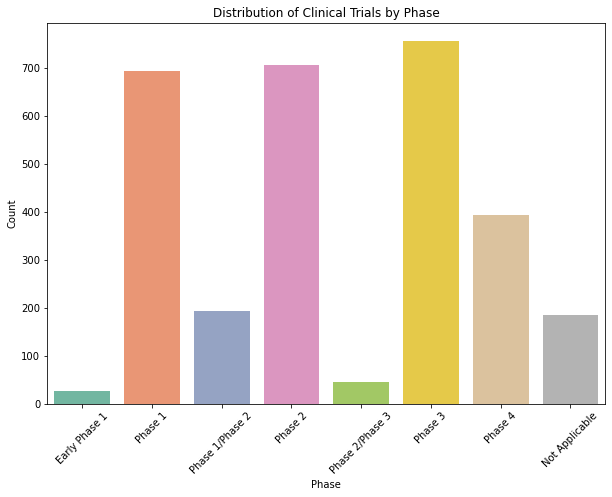

In [86]:
# Plot the distribution of clinical trials by phase

# Select only 'NCTId' and 'phase' columns
phase_df = vax_trials[['nct_id', 'phase']]
phase_df = phase_df.drop_duplicates()


# Define the order for phases
phase_order = ['Early Phase 1', 'Phase 1', 'Phase 1/Phase 2', 'Phase 2', 'Phase 2/Phase 3', 'Phase 3', 'Phase 4', 'Not Applicable']


# Set the figure size
plt.figure(figsize=(10, 7))

# Plot a countplot
sns.countplot(x='phase', data=phase_df, palette='Set2', order=phase_order)
plt.title('Distribution of Clinical Trials by Phase')
plt.xlabel('Phase')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

- Identify the most frequently reported reasons for patients discontinuing their participation in clinical trials related to vaccine interventions.

In [90]:
# Utilize the 'sum_count' function to extract the 'reason_dropout' and 'count_dropout' columns from the dataframe
# and sum the values in the 'count_dropout' column

reason_sum = sum_count(vax_trials_with_dropouts, 'reason_dropout', 'count_dropout')
reason_sum.head()

,reason_dropout,TotalSum
0,*clinical ae,4.0
1,*pregnancy,14.0
2,6-month contact; withdraw before vax 2,123.0
3,administrative problems,1.0
4,administrative reason,723.0


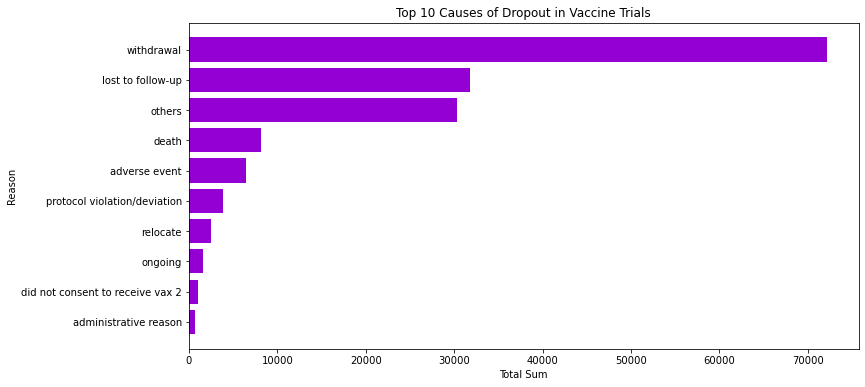

In [91]:
# Plot
dataframe = reason_sum
x_column = 'reason_dropout'
y_column = 'TotalSum'
title = 'Top 10 Causes of Dropout in Vaccine Trials'
xlabel = 'Total Sum'
ylabel = 'Reason'

plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel)


- Determine the most prevalent conditions in vaccine clinical trials

In [92]:
# Utilize the 'total_count' function to extract the 'nct_id' and 'condition_name' columns from the dataframe
# and compute the total count of unique conditions present in the 'condition_name' column.


condition_counts = total_count(vax_trials, 'nct_id', 'condition_name')
condition_counts.head()

,condition_name,TotalCount
0,influenza,403
1,hiv infections,89
2,covid-19,58
3,hepatitis b,54
4,healthy,47


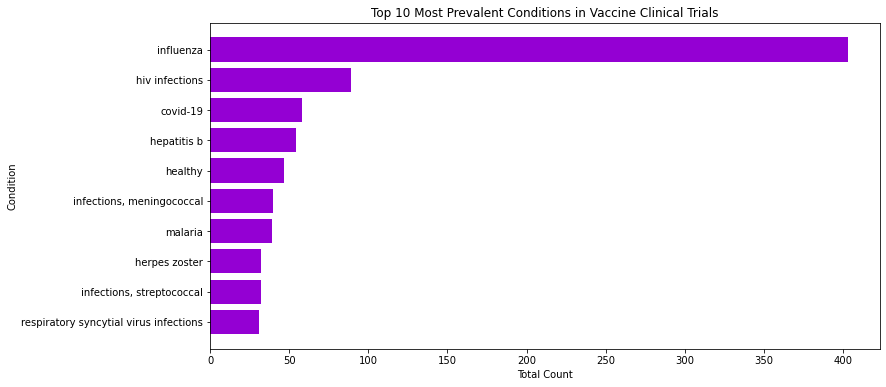

In [94]:
# Plot

dataframe = condition_counts
x_column = 'condition_name'
y_column = 'TotalCount'
title = 'Top 10 Most Prevalent Conditions in Vaccine Clinical Trials'
xlabel = 'Total Count'
ylabel = 'Condition'

plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel)

- Determine the prevalence of vaccines utilized as interventions in clinical trials 

In [95]:
# Utilize the 'total_count' function to extract the 'nct_id' and 'vaccine_name' columns from the dataframe
# and compute the total count of unique vaccines present in the 'vaccine_name' column.

interventions_count = total_count(vax_trials, 'nct_id', 'vaccine_name')
interventions_count.head()

,vaccine_name,TotalCount
0,influenza vaccine,37
1,rabies vaccine,19
2,hepatitis b vaccine,17
3,pfspz vaccine,17
4,13-valent pneumococcal conjugate vaccine,15


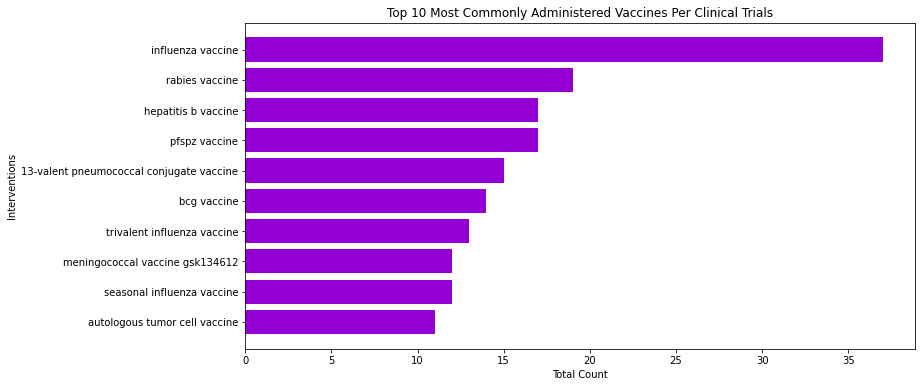

In [96]:
# Plot
dataframe = interventions_count
x_column = 'vaccine_name'
y_column = 'TotalCount'
title = 'Top 10 Most Commonly Administered Vaccines Per Clinical Trials'
xlabel = 'Total Count'
ylabel = 'Interventions'

plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel)

- Summary of participants' progress in the study, including the count of those who started and completed the trial.

In [100]:
# use the 'sum_count' function to select the 'Status' and 'Count' columns and sum the values in the 'Count' column

progress_sum = sum_count(vax_trials_with_milestones, 'participant_progress', 'participants_number')
progress_sum.head()

,participant_progress,TotalSum
0,1 year visit,254.0
1,1- month post-op,13.0
2,15-day follow-up,146.0
3,3 month follow-up,143.0
4,3-6 months post-op,12.0


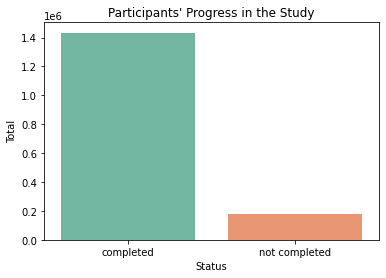

In [101]:
# Filter rows where the 'Title' column is either 'completed' or 'not completed'
progress_filtered = progress_sum[progress_sum['participant_progress'].isin(['completed', 'not completed'])]

# Plot a barplot
sns.barplot(x='participant_progress', y='TotalSum', data=progress_filtered, palette='Set2')
plt.title('Participants\' Progress in the Study')
plt.xlabel('Status')
plt.ylabel('Total')
plt.show()


- Identify the most prevalent adverse events in vaccine clinical trials

In [102]:
ae_sum = sum_count(vax_trials_with_ae, 'adverse_event_term', 'subjects_affected')
ae_sum = ae_sum.sort_values(by='TotalSum', ascending=False)
ae_sum.head()

,adverse_event_term,TotalSum
4316,irritability,682157.0
4068,injection site pain,476752.0
6634,pyrexia,449563.0
3291,headache,404256.0
5755,pain,394078.0


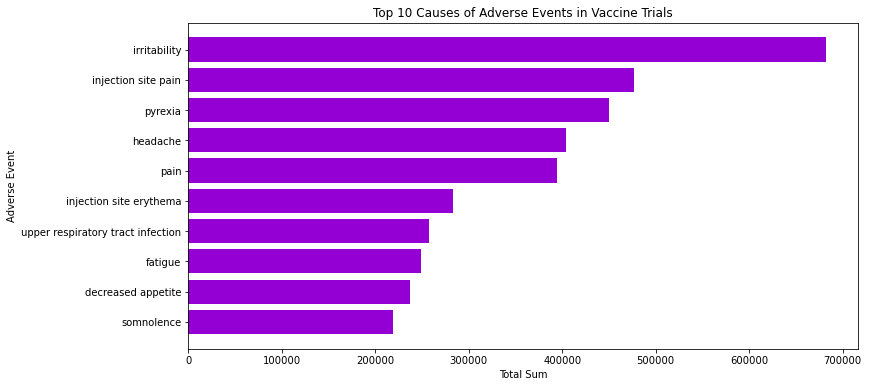

In [103]:
# Plot
dataframe = ae_sum
x_column = 'adverse_event_term'
y_column = 'TotalSum'
title = 'Top 10 Causes of Adverse Events in Vaccine Trials'
xlabel = 'Total Sum'
ylabel = 'Adverse Event'

plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel)

### Preprocessing the Data for Machine Learning Models

Merge all the necessary dataframes:

- **pivot_ae**, which contains all adverse events occurring per vaccine clinical trial.
- **aggregated_milestones**, which includes information about how many people completed or did not complete the clinical trial, including the target column 'Dropout.'
- **pivot_dropouts**, which contains information about the reasons for the dropouts.


In [104]:
# Test

df_test = pd.merge(aggregated_milestones, pivot_dropouts, on=['nct_id', 'overall_status', 'phase', 'enrollment', 'vaccine_name', 'condition_name', ], how='left')
df_test

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,participants_number_completed,participants_number_not_completed,dropout,*clinical ae,...,withdrawn before any study vaccination,withdrawn due to non-compliance,withdrawn unspecified reason,"withdrawn, ahct not suitable treatment","withdrawn, chemo not suitable treatment",withdrew before vaccination,withdrew consent,wrong group allocation,wrong treatment number allocation,year 2 screening failure
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",436.0,14.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections,666.0,134.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,"breast cancer, melanoma, sarcoma, gastrointest...",15.0,2.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NCT00434577,Completed,Phase 2,715.0,"herpes zoster vaccine gsk1437173a low dose, he...",herpes zoster,2697.0,13.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NCT00616421,Completed,Phase 3,2907.0,licensed meningococcal acwy vaccine,meningococcal infections,2802.0,105.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,NCT00108732,Completed,Phase 2,50.0,"recombinant fowlpox-psa(l155)/tricom vaccine, ...","recurrent prostate carcinoma, stage i prostate...",62.0,19.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1102,NCT02872311,Completed,Not Applicable,179.0,"high dose influenza vaccine, adjuvanted influe...",immune response,172.0,7.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1103,NCT01859143,Completed,Phase 4,300.0,trivalent influenza vaccine,"influenza, healthy",298.0,2.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1104,NCT01381575,Completed,Phase 3,1447.0,gsk biologicals' hpv vaccine 580299,"infections, papillomavirus",1362.0,85.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
# Fill NaN with 0
df_test.fillna(0, inplace=True)

In [106]:
# Missing values
df_test.isnull().sum()

nct_id                               0
overall_status                       0
phase                                0
enrollment                           0
vaccine_name                         0
                                    ..
withdrew before vaccination          0
withdrew consent                     0
wrong group allocation               0
wrong treatment number allocation    0
year 2 screening failure             0
Length: 410, dtype: int64

In [107]:
# Check for duplicates
duplicates = df_test.duplicated()
print(duplicates.value_counts())

False    1106
dtype: int64


Dummy Variables

- dummy variables are created to handle categorical variables. They transform each category within a variable into its own binary identifier.

In [108]:
# dummy variables
df_test = pd.get_dummies(df_test, columns=['condition_name'], prefix=['condition'])
df_test.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,participants_number_completed,participants_number_not_completed,dropout,*clinical ae,*pregnancy,...,condition_virus diseases,"condition_virus diseases, rna virus infections, respiratory tract diseases, respiratory tract infections","condition_virus diseases, rna virus infections, respiratory tract diseases, respiratory tract infections, influenza","condition_virus diseases, rna virus infections, respiratory tract infections, respiratory tract disease, influenza","condition_vomiting, diarrhea, fever",condition_west nile fever,"condition_whole cell pertussis, diphtheria, hepatitis b, tetanus, haemophilus influenzae type b","condition_whooping cough, neoplasms, glandular and epithelial, diphtheria, tetanus, meningitis",condition_yellow fever,condition_zika virus infection
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",436.0,14.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",666.0,134.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,15.0,2.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,NCT00434577,Completed,Phase 2,715.0,"herpes zoster vaccine gsk1437173a low dose, he...",2697.0,13.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,NCT00616421,Completed,Phase 3,2907.0,licensed meningococcal acwy vaccine,2802.0,105.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Selecting Variables

The data for the model will be a subset of the variables. The **x** dataframe will contain features that could serve as good predictors for patient dropout in clinical trials. The **y** dataframe will include the target column, in this case, the 'Dropout' column, indicating whether there was any dropout in that clinical trial. 'Dropout' is a binary variable, equal to either 1 (dropout), or 0 (no dropout).

In [109]:
x = df_test.drop(['nct_id', 'overall_status', 'phase', 'vaccine_name', 'participants_number_completed', 'participants_number_not_completed', 'dropout' ], axis=1)
y = df_test['dropout']

Splitting the Data

Next, the data needs to be divided into training and validation sets. In this split, 25% of the data is reserved for final validation, while 75% is allocated for training the model. 

In [110]:
#Validation chunk size
val_size = 0.25

#Split the data into chunks
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=val_size, random_state = 0)

#### Prediction

- **Model Building:** For this project, four common algorithms will be used to make predictions:
  1. Logistic Regression
  2. K Nearest Neighbor
  3. Decision Trees
  4. Random Forests

#### Evaluation Metrics

Within the models, various values can be utilized to evaluate their performance:

Legend: T = true, F = false, P = positive, N = negative

- **Accuracy:** is the correct values divided by total values. (TP + TN)/(TP + FP + TN + FN).
- **Precision:** is the True Positives divided by the sum of True Positives and False Negatives. So precision is the values of the true positives divided by the actual positive values. TP/(TP + FP).
- **Recall:** is the True Positives divided by the sum of True Positives and False Positives. So recall is the values of the true positives divided by the positive guesses. TP/(TP + FN).
- **F1-score:** weighted average of precision and recall. 2*((Precision*Recall)/(Precision+Recall)).
- **Macro Avg:** is the unweighted mean value of precision and recall. 
- **Weighted Avg:** is the weighted mean value of precision and recall by the support values for each class.
- **Support:** is the number of observations in class to predict.


##### Logistic Regression

- logistic regression is used to predict the probability of group membership.

In [111]:
# Create and fit the logistic regression model

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)
y_pred_prob = lr_model.predict_proba(x_test)

Once the model is trained, we can access a few useful attributes:

- `model.coef_` is a vector of the coefficients of each feature
- `model.intercept_` is the intercept

The coefficients can be interpreted as follows:

- **Large positive coefficient:** a one unit increase in that feature is associated with a large increase in the log odds (and therefore probability) of a datapoint belonging to the positive class (the outcome group labeled as 1)
- **Large negative coefficient:** a one unit increase in that feature is associated with a large decrease in the log odds/probability of belonging to the positive class.
- **Coefficient of 0:** The feature is not associated with the outcome.

In [112]:
# Print the intercept and coefficients
#print(lr_model.coef_)
print(lr_model.intercept_)

[-0.13039446]


In [113]:
# Print the evaluation metrics: 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.90      0.64        31
           1       0.99      0.88      0.93       246

    accuracy                           0.88       277
   macro avg       0.74      0.89      0.78       277
weighted avg       0.93      0.88      0.90       277



Confusion Matrix

In [114]:
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_pred), 
    index=['actual no', 'actual yes'], 
    columns=['predicted no', 'predicted yes']
)

print(test_conf_matrix)

            predicted no  predicted yes
actual no             28              3
actual yes            29            217


ROC Curve and AUC

- In the plot below, the True Positive Rate (TPR = TP / TP + FN) is on the y-axis and the False Positive Rate (FPR = FP / TN + FP) is on the x-axis. 
- The ROC (Receiver Operating Characteristic) curve is the orange line and the dashed blue line is the Dummy Classification line, which is the equivalent of random guessing.
- The ROC curve can help us decide on a threshold that best fits our specific classification problem.
- While the ROC curve measures the probabilities, the AUC (Area Under the Curve) gives us a single metric for separability. The AUC tells us how well our model can distinguish between the two classes. An AUC score close to 1 is a near-perfect classifier, whereas a value of 0.5 is equivalent to random guessing.

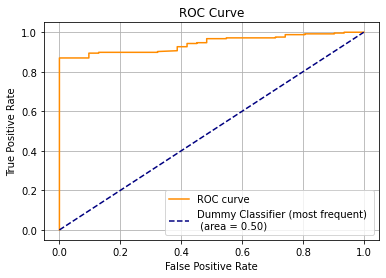

In [115]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve')

clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(x_train, y_train)
roc_auc = roc_auc_score(y_test, clf.predict_proba(x_test)[:,1] )
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
plt.plot(fpr, tpr, color='navy',linestyle='--', label='Dummy Classifier (most frequent) \n (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.legend(loc="lower right")
plt.show()

In [116]:
# Print the ROC_AUC score 
roc_auc = roc_auc_score(y_test, y_pred_prob[:,1])
print(roc_auc)

0.943089430894309


Stratification
- the data is sorted into subgroups to ensure a nearly equal class distribution in your train and test sets.

In [117]:
# Stratified Sampling

x_train_str, x_test_str, y_train_str, y_test_str = train_test_split(x, y, test_size=val_size, random_state = 0, stratify = y)

# Model predictions after stratified sampling
lr_model.fit(x_train_str, y_train_str)
y_pred_str = lr_model.predict(x_test_str)

In [118]:
# Print the evaluation metrics
print(classification_report(y_test_str, y_pred_str))

              precision    recall  f1-score   support

           0       0.55      0.93      0.69        42
           1       0.99      0.86      0.92       235

    accuracy                           0.87       277
   macro avg       0.77      0.90      0.81       277
weighted avg       0.92      0.87      0.89       277



##### K Nearest Neighbor
- classification algorithm. Data points with similar attributes tend to fall into similar categories.


In [119]:
knn_model = KNeighborsClassifier(n_neighbors = 5) #default value
knn_model.fit(x_train, y_train)
knn_y_pred = knn_model.predict(x_test)

In [120]:
# Evaluation metrics
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           0       0.32      0.55      0.40        31
           1       0.94      0.85      0.89       246

    accuracy                           0.82       277
   macro avg       0.63      0.70      0.65       277
weighted avg       0.87      0.82      0.84       277



In [121]:
# Find the best k

accuracies = []
for k in range(1, 101):
  knn_model = KNeighborsClassifier(n_neighbors = k)
  knn_model.fit(x_train, y_train)
  accuracies.append(knn_model.score(x_test, y_test)) 

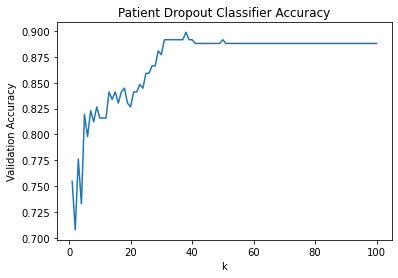

In [122]:
k_list = list(range(1, 101))

plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title('Patient Dropout Classifier Accuracy')
plt.show()

##### Decision Trees

- The goal of a decision tree model is to separate the classes as effectively as possible.
- The default value for `max_depth` is `None`, which means that nodes are expanded until all leaves are pure or until all leaves contain fewer than `min_samples_split` samples.

In [123]:
cart_model = DecisionTreeClassifier()
cart_model.fit(x_train, y_train) 
cart_y_pred = cart_model.predict(x_test) 
print(f'Decision tree depth: {cart_model.get_depth()}')


Decision tree depth: 50


In [ ]:
# Plotting the Tree
# plt.figure(figsize=(20,12))
# tree.plot_tree(cart_model, feature_names = x_train.columns, max_depth=5, class_names = ['no dropout', 'dropout'], label='all', filled=True)
# plt.tight_layout()
# plt.show()

In [124]:
# Text-based visualization of the tree (View this in the Output terminal!)
print(tree.export_text(cart_model, feature_names = x_train.columns.tolist()))

|--- withdrawal <= 0.50
|   |--- lost to follow-up <= 0.50
|   |   |--- adverse event <= 0.50
|   |   |   |--- enrollment <= 270.50
|   |   |   |   |--- protocol violation/deviation <= 0.50
|   |   |   |   |   |--- disease progression <= 0.50
|   |   |   |   |   |   |--- physician decision <= 0.50
|   |   |   |   |   |   |   |--- enrollment <= 10.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- enrollment >  10.50
|   |   |   |   |   |   |   |   |--- others <= 0.50
|   |   |   |   |   |   |   |   |   |--- condition_hepatitis b vaccine <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- progressive disease <= 1.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 40
|   |   |   |   |   |   |   |   |   |   |--- progressive disease >  1.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- condition_hepatitis b vaccine >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|  

In [125]:
# Evalution metrics
print(classification_report(y_test, cart_y_pred))

              precision    recall  f1-score   support

           0       0.48      0.77      0.59        31
           1       0.97      0.89      0.93       246

    accuracy                           0.88       277
   macro avg       0.72      0.83      0.76       277
weighted avg       0.91      0.88      0.89       277



##### Random Forests

In [126]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=.2)

In [127]:
# Instantiate random forest classifier, fit and score with default parameters
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf.score(x_test, y_test)
print(f'Accuracy score for default random forest: {round(rf.score(x_test, y_test)*100,3)}%')

Accuracy score for default random forest: 89.64%


In [128]:
#Tune the hyperparameter max_depth over a range from 1-25, save scores for test and train set

np.random.seed(0)
accuracy_train=[]
accuracy_test = []
depths = range(1,26)
for i in depths:
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    accuracy_test.append(accuracy_score(y_test, rf.predict(x_test)))
    accuracy_train.append(accuracy_score(y_train, rf.predict(x_train)))

In [129]:
#Find the best accuracy and at what depth that occurs
best_acc= np.max(accuracy_test)
best_depth = depths[np.argmax(accuracy_test)]
print(f'The highest accuracy on the test is achieved when depth: {best_depth}')
print(f'The highest accuracy on the test set is: {round(best_acc*100,3)}%')

The highest accuracy on the test is achieved when depth: 23
The highest accuracy on the test set is: 91.441%


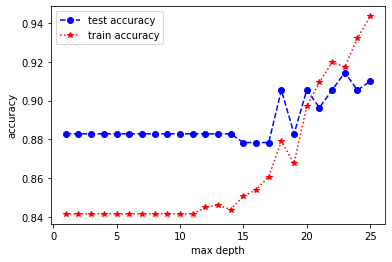

In [130]:
#Plot the accuracy scores for the test and train set over the range of depth values  
plt.plot(depths, accuracy_test,'bo--',depths, accuracy_train,'r*:')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.show()

In [131]:
# Save the best random forest model and save the feature importances in a dataframe
best_rf = RandomForestClassifier(max_depth=best_depth)
best_rf.fit(x_train, y_train)
feature_imp_df = pd.DataFrame(zip(x_train.columns, best_rf.feature_importances_),  columns=['feature', 'importance'])
print('Top 5 random forest features:')
print(feature_imp_df.sort_values('importance', ascending=False).iloc[0:5])

Top 5 random forest features:
                          feature  importance
390                    withdrawal    0.178149
139             lost to follow-up    0.173554
0                      enrollment    0.129583
6                   adverse event    0.068129
256  protocol violation/deviation    0.050833
